In [8]:
import cv2
import math
import numpy as np

from matplotlib import pyplot as plt

In [9]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
data_path = "/content/drive/My Drive/Colab Notebooks/DIP/Data"

Mounted at /content/drive


In [10]:
def chessboard_effect(img, dim_square):
    height = img.shape[0]
    length = img.shape[1]

    n_squares_x = math.floor(length / dim_square)
    n_squares_y = math.floor(height / dim_square)

    leftover_x = length % dim_square
    leftover_y = height % dim_square

    x_start = math.floor(leftover_x / 2)
    y_start = math.floor(leftover_y / 2)

    chessboard = np.zeros(shape=(n_squares_y, n_squares_x, 
                                 dim_square, dim_square,
                                 3), 
                          dtype=np.uint8)
    
    for i in range(n_squares_y):
        for j in range(n_squares_x):
            chessboard[i,j] = img[leftover_y+i*dim_square:leftover_y+i*dim_square + dim_square,
                                  leftover_x+j*dim_square:leftover_x+j*dim_square + dim_square]

    return chessboard


def chessboard_black(img, dim):
    chessboard = chessboard_effect(img, dim)

    for i in range(chessboard.shape[0]):
        for j in range(chessboard.shape[1]):
            # chessboard[i,j] = np.zeros((dim,dim,3), dtype=np.uint8)
            if i % 2 == 0:
                if j % 2 == 0:
                    chessboard[i,j] = np.zeros((dim,dim,3), dtype=np.uint8)
            else:
                if j % 2 == 1:
                    chessboard[i,j] = np.zeros((dim,dim,3), dtype=np.uint8)
    return reconstruction(chessboard, dim)


def reconstruction(chessboard, dim_square):
    img = np.zeros(shape=(chessboard.shape[0]*dim_square,
                          chessboard.shape[1]*dim_square,
                          3),
                   dtype=np.uint8)
    for i in range(chessboard.shape[0]):
        for j in range(chessboard.shape[1]):
            img[i*dim_square:i*dim_square+dim_square,
                j*dim_square:j*dim_square+dim_square] = chessboard[i,j]
    return img

In [11]:
def right_rotation(tensor):
    if len(tensor.shape) == 3:
        result = np.zeros(shape=(tensor.shape[1], tensor.shape[0], 3), dtype=tensor.dtype)
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                result[j,tensor.shape[0]-1-i] = tensor[i,j]
        return result
    else:
        tshape = tensor.transpose(
            np.concatenate([[1,0],np.arange(2,tensor.ndim)])
            ).shape
        result = np.zeros(shape=tshape, dtype=tensor.dtype)
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                result[j,tensor.shape[0]-1-i][:,:] = right_rotation(tensor[i,j])
        return result


def roto_superposition(img, dim_square):
    layer_a = chessboard_effect(img, dim_square)
    layer_b = right_rotation(layer_a)

    n_pixels_x_y = min(layer_a.shape[0], layer_a.shape[1])

    result = np.zeros(shape=(n_pixels_x_y, n_pixels_x_y, 
                             dim_square, dim_square,
                             3))

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if i % 2 == 0:
                if j % 2 == 0:
                    result[i,j] = layer_a[i,j]
                else:
                    result[i,j] = layer_b[i,j]
            else:
                if j % 2 == 0:
                    result[i,j] = layer_b[i,j]
                else:
                    result[i,j] = layer_a[i,j]

    return reconstruction(result, dim_square)

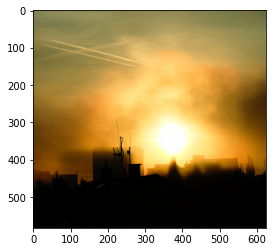

In [12]:
img = cv2.imread(data_path+"/plzen.jpg")

img = img[100:,400:] # Cropping

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

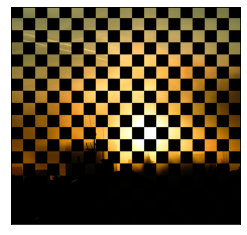

In [13]:
DIM = 32

chess_black = chessboard_black(img, DIM)
plt.imshow(cv2.cvtColor(chess_black,cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

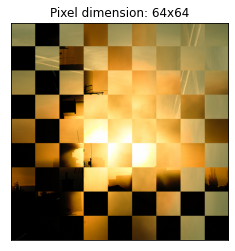

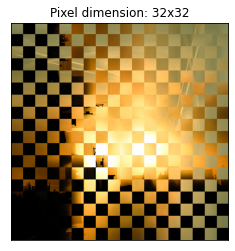

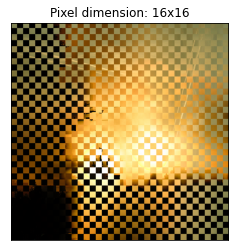

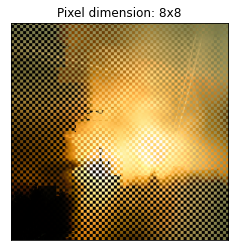

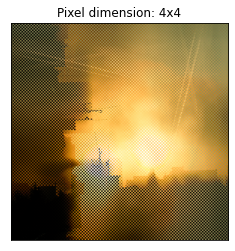

In [14]:
DIM = [64,32,16,8,4]
for dim in DIM:
    roto_superposed = roto_superposition(img, dim)
    plt.imshow(cv2.cvtColor(roto_superposed,cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Pixel dimension: {dim}x{dim}')
    plt.show()